In [1]:
import pandas as pd
import numpy as np
import pickle
import os
import seaborn as sns
import matplotlib.pyplot as plt
from gensim import matutils, models
import gensim.corpora as corpora
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
import scipy.sparse
import re
from gensim.utils import simple_preprocess
import spacy
import scispacy
import en_core_sci_lg
import gensim.corpora as corpora
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from pprint import pprint
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

In [2]:
data=pd.read_csv("data.csv")
data.head()

,cord_uid,source_x,title,doi,abstract,publish_time,authors,journal,url,publish_year,lang
0,1b7bzwb0,Medline,Telemedicine and the rural dementia population...,10.1016/j.maturitas.2020.09.001,BACKGROUND Telemedicine is a timely solution f...,2021-01-01,"Sekhon, Harmehr; Sekhon, Kerman; Launay, Cyril...",Maturitas,https://doi.org/10.1016/j.maturitas.2020.09.00...,2021,en
1,za1odoyf,Medline,Implementing trauma resuscitation protocol in ...,10.4103/njcp.njcp_352_20,Trauma remains the leading cause of death in i...,2021-01-01,"Okoye, O G",Nigerian journal of clinical practice,https://doi.org/10.4103/njcp.njcp_352_20; http...,2021,en
2,z833jqsr,Medline,Evolving public behavior and attitudes towards...,10.1371/journal.pone.0251845,"Facing the COVID-19 pandemic, Taiwan demonstra...",2021-01-01,"Chin, Chih-Yu; Liu, Chang-Pan; Wang, Cheng-Lung",PloS one,https://doi.org/10.1371/journal.pone.0251845; ...,2021,en
3,fhy98qt4,Elsevier; Medline; PMC,Modeling the competitive diffusions of rumor a...,10.1016/j.amc.2020.125536,The interaction between epidemic spreading and...,2021-01-01,"Huang, He; Chen, Yahong; Ma, Yefeng",Appl Math Comput,https://www.sciencedirect.com/science/article/...,2021,en
4,owzb4nue,Medline,Pandemics throughout the centuries.,10.1016/j.clindermatol.2020.12.006,Pandemics have ravished the globe periodically...,2021-01-01,"Schwartz, Robert A; Kapila, Rajendra",Clinics in dermatology,https://doi.org/10.1016/j.clindermatol.2020.12...,2021,en


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95008 entries, 0 to 95007
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   cord_uid      95008 non-null  object
 1   source_x      95008 non-null  object
 2   title         95008 non-null  object
 3   doi           62032 non-null  object
 4   abstract      95008 non-null  object
 5   publish_time  95008 non-null  object
 6   authors       94851 non-null  object
 7   journal       88030 non-null  object
 8   url           64673 non-null  object
 9   publish_year  95008 non-null  int64 
 10  lang          95008 non-null  object
dtypes: int64(1), object(10)
memory usage: 8.0+ MB


# Pre-processing

In [5]:
data['abstract_processed'] = data['Abstract'].map(lambda y: re.sub('[?:!,/.]', '',y))

,cord_uid,source_x,title,doi,abstract,publish_time,authors,journal,url,publish_year,lang,abstract_processed
0,1b7bzwb0,Medline,Telemedicine and the rural dementia population...,10.1016/j.maturitas.2020.09.001,BACKGROUND Telemedicine is a timely solution f...,2021-01-01,"Sekhon, Harmehr; Sekhon, Kerman; Launay, Cyril...",Maturitas,https://doi.org/10.1016/j.maturitas.2020.09.00...,2021,en,background telemedicine is a timely solution f...
1,za1odoyf,Medline,Implementing trauma resuscitation protocol in ...,10.4103/njcp.njcp_352_20,Trauma remains the leading cause of death in i...,2021-01-01,"Okoye, O G",Nigerian journal of clinical practice,https://doi.org/10.4103/njcp.njcp_352_20; http...,2021,en,trauma remains the leading cause of death in i...
2,z833jqsr,Medline,Evolving public behavior and attitudes towards...,10.1371/journal.pone.0251845,"Facing the COVID-19 pandemic, Taiwan demonstra...",2021-01-01,"Chin, Chih-Yu; Liu, Chang-Pan; Wang, Cheng-Lung",PloS one,https://doi.org/10.1371/journal.pone.0251845; ...,2021,en,facing the covid-19 pandemic taiwan demonstrat...
3,fhy98qt4,Elsevier; Medline; PMC,Modeling the competitive diffusions of rumor a...,10.1016/j.amc.2020.125536,The interaction between epidemic spreading and...,2021-01-01,"Huang, He; Chen, Yahong; Ma, Yefeng",Appl Math Comput,https://www.sciencedirect.com/science/article/...,2021,en,the interaction between epidemic spreading and...
4,owzb4nue,Medline,Pandemics throughout the centuries.,10.1016/j.clindermatol.2020.12.006,Pandemics have ravished the globe periodically...,2021-01-01,"Schwartz, Robert A; Kapila, Rajendra",Clinics in dermatology,https://doi.org/10.1016/j.clindermatol.2020.12...,2021,en,pandemics have ravished the globe periodically...


# Bi-grams and Tri-grams

In [7]:
Bi = models.Phrases(words, min_count=6, threshold=110)
Tri = models.Phrases(Bi[words], threshold=110)
Bi_mod = models.phrases.Phraser(Bi)
Tri_mod = models.phrases.Phraser(Tri)

# Tokenizer

In [8]:
nlp = en_core_sci_sm.load(disable=['ner','tagger','parser','textcat'])
def spacy_tokenizer(papers):

    tok = ''
    for token in nlp(papers):
        if not (token.like_num or token.is_punct or token.is_space) \
        and not token.lower_ in stopwords_spacy \
        and token.lemma_!='-pron-':
            tok += f' {str(token.lemma_.lower())}'

    return tok.strip()

In [9]:
nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_words.extend(['sars_cov','patient','doi', 'preprint', 'copyright',  'biorxiv', 'from', 'subject', 're', 'ie', 'st','peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 
    'rights', 'reserved', 'permission', 'used', 'using', 'th', 'rd', 'study', 'covid','covid-19', 'sars-cov-2', 'coronavirus', 'medrxiv', 'license', 'fig', 
    'al.', 'Elsevier', 'PMC', 'CZI'])

# resource https://www.kaggle.com/danielwolffram/topic-modeling-finding-related-articles

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\15107\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
def remove_stopwords(content):
    ans= [word for word in simple_preprocess(str(papers)) if word not in stop_words] for papers in content
    return ans

def Bi(content):
    ans=Bi_mod[papers] for papers in content
    return ans

def Tri(content):
    ans= Tri_mod[Bi_mod[papers]] for papers in content
    return ans

def lem(content):
    ans=stemmer.stem(WordNetLemmatizer().lemmatize(content, pos='v'))
    return ans

In [12]:
nostops = remove_stopwords(words)

Bi = Bi(nostops)

data_lem = lem(Bi, allowed_postags=['NOUN', 'VERB', 'ADV', 'ADJ'])
dic = corpora.Dictionary(data_lem)

content = data_lem
corpus = [dic.papers2bow(text) for text in content]

[['background', 'telemedicine', 'timely', 'solution', 'restriction', 'social', 'distancing', 'place', 'conventional', 'modality', 'healthcare', 'provision', 'geriatric', 'population', 'affect', 'dementia', 'require', 'great', 'access', 'healthcare', 'service', 'particularly', 'rural_areas', 'aim', 'systematic', 'review', 'examine', 'impact', 'telemedicine', 'health', 'outcome', 'elderly', 'individual', 'dementia', 'live', 'rural_areas', 'method', 'systematic', 'review', 'complete', 'use', 'ovid_medline', 'web', 'science', 'acm', 'digital', 'library', 'keyword', 'selection', 'article', 'telemedicine', 'telehealth', 'rural', 'age', 'eld', 'dementia', 'telemedicine', 'rural', 'health', 'rural', 'population', 'hospital', 'rural', 'rural', 'health', 'service', 'aged', 'aging', 'dementia', 'multi', 'infarct', 'dementia', 'vascular', 'dementia', 'article', 'identify', 'screen', 'assess', 'include', 'result', 'study', 'diverse', 'population', 'conduct', 'australia', 'canada', 'korea', 'united_

# Number of Topics

In [26]:
def coherence_values(dic, corpus, content, limit, start=2, step=3):
    model = []
    values = []
    for topics in range(start, limit, step):
        model = models.LdaMulticore(corpus=corpus, num_topics=topics, id2word=dic)
        model.append(model)
        coherencemodel = CoherenceModel(model=model, texts=content, dictionary=dic, coherence='c_v')
        values.append(coherencemodel.get_coherence())
    return model, values

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [27]:
model, values = coherence_values(dictionary=dic, corpus=corpus, texts=data_lem, start=4, limit=30, step=2)

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


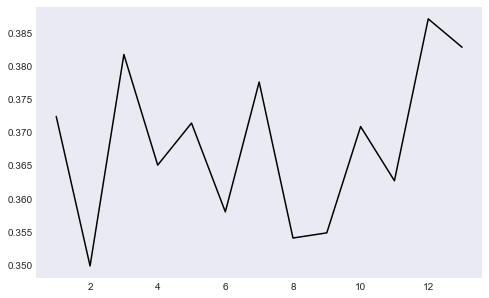

In [78]:
fig,ax = plt.subplots(figsize=(8,5))
ax.plot(range(1,14),values,color='black')

In [62]:
best = values.index(max(values))
best_model = model[best]
print(f''' {x[best]} topics has the highest score of {values[best]}''')

 26 topics has the highest score of 0.38705127685161494


c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Topic Model

In [30]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.95,min_df=0.1)
tfidf = tfidf_vectorizer.fit_transform(list(corpus))
lda_model = models.LdaMulticore(corpus=corpus, num_topics=26, id2word = dic, passes = 10) 
lda_model = lda_model.fit(tfidf)

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [65]:
topics=[]
for i in range(0,26):
    topiclist=[]
    for pharase, w in lda_model.show_topic(i, topn=20):
        topiclist.append((pharase, round(w,3)))
    topics.append(topiclist)

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [66]:
df = pd.DataFrame([', '.join([pharase for pharase, w in topic]) for topic in topics], columns = ['Terms per Topic'], index=['Topic'+str(t) for t in range(1, lda_model.num_topics+1)] )
pd.set_option('display.max_colwidth', -1)
df

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """


,Terms per Topic
Topic1,"cancer, tumor, treatment, survivor, stage, survival, therapy, malaria, delay, breast_cancer, chemotherapy, oncology, thyroid, lung, em, bc, immunotherapy, car, abortion, recurrence"
Topic2,"risk, worker, mask, healthcare, use, infection, face, measure, hcw, practice, knowledge, disease, transmission, control, prevention, exposure, dental, work, medical, preventive"
Topic3,"activity, physical, exercise, pain, function, obesity, rehabilitation, injury, intervention, cardiac, chronic, functional, diet, opioid, pd, improve, disability, change, cognitive, week"
Topic4,"drug, use, activity, compound, potential, property, protein, inhibitor, structure, site, target, show, agent, binding, interaction, anti, antiviral, molecule, high, molecular"
Topic5,"economic, market, financial, effect, cost, sector, industry, business, growth, impact, economy, consumer, et_al, company, crisis, firm, price, return, investment, veteran"
Topic6,"research, system, development, provide, approach, new, review, challenge, discuss, paper, base, strategy, future, well, develop, process, management, focus, pandemic, current"
Topic7,"vaccine, vaccination, dose, efficacy, influenza, trial, safety, receive, vaccinate, response, effective, mrna, immunization, phase, protection, uptake, population, second, clinical, immunity"
Topic8,"cell, protein, response, immune, expression, disease, ace, receptor, induce, mechanism, cd, role, gene, effect, increase, tissue, human, inflammatory, target, show"
Topic9,"health, pandemic, public, social, community, people, work, impact, service, need, policy, crisis, support, experience, life, care, access, response, individual, population"
Topic10,"student, online, program, education, training, learning, participant, use, school, experience, survey, medical, virtual, method, university, result, face, interview, base, practice"


c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


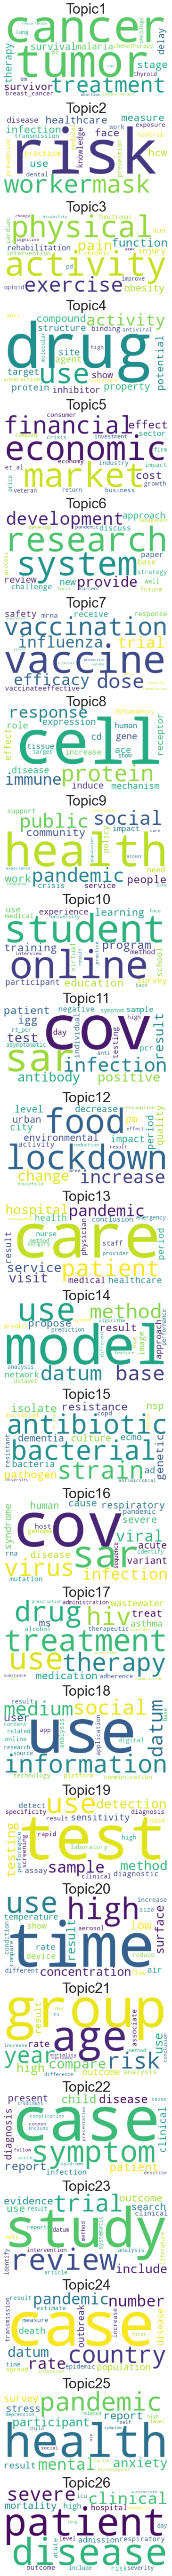

In [70]:
wc = WordCloud(background_color="white", max_font_size=150, random_state=42)
plt.rcParams['figure.figsize'] = [100, 100]
for i in range(26):
    wc.generate(text=df["Terms per Topic"][i])
    plt.subplot(26, 1, i+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(df.index[i], size=30)
plt.show()

# Visualize Topics

In [69]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.sklearn.prepare(lda_model, tfidf, tfidf_vectorizer)
vis

c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
c:\users\15107\appdata\local\programs\python\python37\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)
